# Midterm 3, Assignment 1 - Gaetano Barresi [579102]

A Denoising Autoencoder (DAE) is a neural network that learns robust latent representations by reconstructing clean inputs from corrupted data. Unlike standard autoencoders that simply reconstruct the original inputs, a DAE must remove noise from artificially corrupted inputs and discover stable features that capture the true data distribution. The goal of this work is to train two versions of a DAE on the CIFAR10 dataset, one using dense layers and one using convolutional layers and and to compare their performance.

The architecture of a DAE has the following form:

$$
\
[Input] → [Corruption] → [Encoder] → [Latent Code] → [Decoder] → [Reconstruction]
\
$$

$[Input]$ is self-explanatory. $[Corruption]$ is the stage where we inject artificial noise to the input through some noise process $C(\hat{x} ∣ x)$ and obtain $\hat{x}$, a corrupted version of the original input. In this work the corruption process is done via standard Gaussian noise, so:

$$
\
\hat{x} = x + ϵ, \ ϵ ∼ 𝒩(0, σ^2).
\
$$

$[Encoder]$ $f()$ maps noisy input $\hat{x}$ to latent representation $z$:

$$
\
z = f(\hat{x}) ∈ ℝᵈ,
\
$$

where $d << input\_dim$. Learned $[Latent Code]$ $z$ should be robust to partial destruction of the input.
$[Decoder]$ $g()$ reconstructs clean input from $z$:

$$
\
x' = g(z) ≈ x,
\
$$

where $x'$ is our $[Reconstruction]$.

The "magic" of DAEs lies in their bottleneck architecture. As data passes through the encoder, the network gradually compresses the input while stripping away noise and preserving only the most essential features. This forced dimensionality reduction creates a distilled latent representation containing only the core patterns needed for reconstruction. The decoder then reverses this process, carefully rebuilding the clean input from these compressed features layer by layer. By training on noisy-clean pairs, the network learns to discard random corruptions during compression while maintaining the structural integrity needed for accurate reconstruction.

More formally, the DAE is trained to minimize the loss function

$$
\
L = (x, g(f(\hat{x}))),
\
$$

or, using a probabilistic interpretation, the DAE learns the denoising distribution

$$
\
P(x|\hat{x})
\
$$

by minimizing

$$
\
-log P(x|z = f(\hat{x})).
\
$$

After this brief introduction, we proceed with the implementation. First, we need to load and preprocess the dataset. We normalize the CIFAR-10 data to the range [-1, 1] to achieve several benefits such as: compatibility with the tanh activation, effective noise handling due to the symmetric range that ensures Gaussian noise is equally well-handled in both positive and negative directions, gradient flow optimization, numerical stability.

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# transform for CIFAR-10, normalizing to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Range: [-1, 1]
])
# Load TR set
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
# Load TS set
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=100, shuffle=False)

print("Data loaded successfully.")

Data loaded successfully.


To implement the DAE, we subclass PyTorch’s `nn.Module` base class, inheriting its core functionality for neural network operations. With a single class we can specify which kind of DAE to instantiate, a dense or a convolutional one.

In the convolutional DAE's architecture, the encoder part processes input images through successive 3x3 convolutional kernels: first expanding to 64 channels while maintaining the original 32x32 resolution via padding, then downsampling to 16x16 through max pooling, followed by 128-channel convolution and another downsampling to 8x8, before final compression into 256 channels. Each convolutional operation is followed by ReLU activation for non-linearity. The decoder mirrors this architecture with 3x3 convolutions, first expanding from 256 to 128 channels at 8x8 resolution, then upsampling to 16x16, followed by 64-channel convolution and final upsampling back to the original 32x32 dimensions. The reconstruction concludes with a 3-channel output using `tanh` activation to match the normalized input range.

The dense DAE employs a symmetrical fully-connected architecture with three encoding layers and three decoding layers. The encoder progressively compresses the input through linear transformations: first reducing the 3072-dimensional input to 1024 neurons, then to 512 neurons, and finally to a 256 neuron bottleneck layer. Each layer uses ReLU activation to introduce non-linearity while maintaining sparse representations. The decoder precisely mirrors this structure in reverse order, expanding from 256 to 512 neurons, then to 1024 neurons, before reconstructing the original 3072 dimensional output. The final layer applies `tanh` activation, chosen specifically for its compatibility with our [-1, 1] normalized inputs. This symmetric compression-decompression pathway, combined with `tanh`'s balanced gradient properties and zero-centered output range, enables effective reconstruction while avoiding the positive-value bias that would occur with sigmoid activation.

The class has methods to train and evaluate the DAE:
- `train_model()` is a classical training loop. We use MSE loss, Adam optimizer and a learnig rate of 1e-4. We also use the function `add_noise()` inside the training loop
to corrupt the images with a noise factor of $\sigma = 0.2$, a standard value with a good robustness/quality trade-off.

- `evaluate()` is the function used to quantitatively assess our DAE's reconstruction quality. We employ two metrics: Peak Signal-to-Noise Ratio (PSNR) and Structural Similarity Index (SSIM).

PSNR measures pixel-level accuracy between clean and reconstructed images. It directly relates to the MSE loss used during training

$$
\
PSNR = 10 \cdot \log_{10}\left(\frac{MAX_I^2}{MSE}\right),
\
$$

where $MAX_I$ is the maximum possible pixel value and $MSE$ is the mean squared error across all pixels/channels.
Higher values indicates better recontruction. In CIFAR-10 a typical range is 25-35 dB.
PSNR uses the decibel (dB) scale because it quantifies the ratio between maximum possible signal power and noise power, so the image's pixel value range and reconstruction error.

SSIM evaluates perceptual quality by comparing luminance (mean intensity), contrast (standard deviation) and structure (normalized cross-correlation). It is a metric that matches human vision better than pixel-wise metrics.

$$
\
SSIM(x,y) = \frac{(2\mu_x\mu_y + C_1)(2\sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)},
\
$$

where $\mu$ is local mean, $\sigma$ is standard deviation, $\sigma_{xy}$ is cross-covariance and $C_1, C_2$ are stability costants.
SSIM ranges [-1, 1] with 1 = perfect match. Values > 0.8 indicate good recontruction; values > 0.9 indicate excellent reconstruction.

- `visualize_result()` is just a function to plot some noisy vs reconstructed vs clean images and have a visualization of DAE's performance.

Inside the next code block we can find the implementation of the whole class. The training and test will follow immediately afterwards.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt


class DAE(nn.Module):
    def __init__(self, mode=None):
        super(DAE, self).__init__()

        self.mode = mode

        if mode == 'conv':
            # Convolutional Encoder
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 64, 3, padding=1),   # 32x32
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(64, 128, 3, padding=1), # 16x16
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(128, 256, 3, padding=1) # 8x8
            )
            # Convolutional Decoder
            self.decoder = nn.Sequential(
                nn.Conv2d(256, 128, 3, padding=1),  # 8x8
                nn.ReLU(),
                nn.Upsample(scale_factor=2),
                nn.Conv2d(128, 64, 3, padding=1),   # 16x16
                nn.ReLU(),
                nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 3, 3, padding=1),     # 32x32
                nn.Tanh()
            )
        elif mode == 'dense':
            # Dense Encoder
            self.encoder = nn.Sequential(
                nn.Linear(3 * 32 * 32, 1024),
                nn.ReLU(),
                nn.Linear(1024, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU()
            )
            # Dense Decoder
            self.decoder = nn.Sequential(
                nn.Linear(256, 512),
                nn.ReLU(),
                nn.Linear(512, 1024),
                nn.ReLU(),
                nn.Linear(1024, 3 * 32 * 32),
                nn.Tanh()
            )
        else:
            raise ValueError("Invalid mode. Choose 'conv' or 'dense'.")


    def forward(self, x):
        if self.mode == 'conv':
            x = self.encoder(x)
            x = self.decoder(x)
        else:
            x = x.view(x.size(0), -1)  # Flatten to (batch_size, 3072)
            x = self.encoder(x)
            x = self.decoder(x)
            x = x.view(-1, 3, 32, 32)  # Reshape to image dimensions
        return x
    

    def add_noise(self, inputs, noise_factor=0.2):
        noise = noise_factor * torch.randn_like(inputs)
        noisy = inputs + noise
        return torch.clamp(noisy, -1., 1.)  # CIFAR-10 is normalized to [-1, 1]


    def train_model(self, train_loader, num_epochs=20, lr=1e-4, print_interval=100):
        #parameter print_interval (int): Print loss every N examples

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        
        self.train()  # Set to training mode
        for epoch in range(num_epochs):
            for batch_idx, (clean_imgs, _) in enumerate(train_loader):
                clean_imgs = clean_imgs.to(device)
                
                # Add noise and reconstruct
                noisy_imgs = self.add_noise(clean_imgs)
                reconstructed = self(noisy_imgs)
                
                # Compute loss and update
                loss = self.criterion(reconstructed, clean_imgs)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                # Print progress
                if batch_idx % print_interval == 0:
                    print(f"Epoch [{epoch+1}/{num_epochs}], Batch {batch_idx}, Loss: {loss.item():.4f}")


    def evaluate(self, test_loader, noise_factor=0.2):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)

        #Compute PSNR and SSIM on test set
        self.eval()  # Set to evaluation mode
        total_psnr = 0.0
        total_ssim = 0.0
        num_samples = 0
        
        with torch.no_grad():
            for clean_imgs, _ in test_loader:
                clean_imgs = clean_imgs.to(device)
                noisy_imgs = self.add_noise(clean_imgs, noise_factor)
                reconstructed = self(noisy_imgs)
                
                # Convert to numpy (CPU) for metric calculation
                clean_np = clean_imgs.cpu().numpy()
                recon_np = reconstructed.cpu().numpy()
                
                # Compute metrics per image
                for i in range(clean_np.shape[0]):
                    # PSNR (higher is better)
                    total_psnr += psnr(clean_np[i], recon_np[i], data_range=2.0)  # data_range=2 for [-1,1]
                    
                    # SSIM (higher is better, multichannel=True for RGB)
                    total_ssim += ssim(clean_np[i].transpose(1,2,0), 
                                     recon_np[i].transpose(1,2,0), 
                                     data_range=2.0, 
                                     channel_axis=2)
                
                num_samples += clean_np.shape[0]
        
        avg_psnr = total_psnr / num_samples
        avg_ssim = total_ssim / num_samples
        return avg_psnr, avg_ssim
    

    def visualize_results(self, test_loader, num_images=5):
        #Plot noisy vs reconstructed vs clean images
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)

        self.eval()
        with torch.no_grad():
            clean_imgs, _ = next(iter(test_loader))
            clean_imgs = clean_imgs.to(device)[:num_images]
            noisy_imgs = self.add_noise(clean_imgs)
            reconstructed = self(noisy_imgs)
            
            # Denormalize to [0,1] for plotting
            clean_imgs = (clean_imgs + 1) / 2
            noisy_imgs = (noisy_imgs + 1) / 2
            reconstructed = (reconstructed + 1) / 2
            
            fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images*2))
            for i in range(num_images):
                axes[i,0].imshow(noisy_imgs[i].cpu().permute(1,2,0))
                axes[i,0].set_title("Noisy")
                axes[i,1].imshow(reconstructed[i].cpu().permute(1,2,0))
                axes[i,1].set_title("Reconstructed")
                axes[i,2].imshow(clean_imgs[i].cpu().permute(1,2,0))
                axes[i,2].set_title("Clean")
                for ax in axes[i]:
                    ax.axis('off')
            plt.tight_layout()
            plt.show()

In [3]:
# Initialize Convolutional DAE model
cdae = DAE(mode='conv')
cdae.train_model(train_loader)
print("CDAE model ready.")

# Initialize Dense DAE model
ddae = DAE(mode='dense')
ddae.train_model(train_loader)
print("DDAE model ready.")

Epoch [1/20], Batch 0, Loss: 0.2393
Epoch [1/20], Batch 100, Loss: 0.0525
Epoch [1/20], Batch 200, Loss: 0.0379
Epoch [1/20], Batch 300, Loss: 0.0280
Epoch [1/20], Batch 400, Loss: 0.0274
Epoch [2/20], Batch 0, Loss: 0.0251
Epoch [2/20], Batch 100, Loss: 0.0248
Epoch [2/20], Batch 200, Loss: 0.0230
Epoch [2/20], Batch 300, Loss: 0.0221
Epoch [2/20], Batch 400, Loss: 0.0234
Epoch [3/20], Batch 0, Loss: 0.0221
Epoch [3/20], Batch 100, Loss: 0.0212
Epoch [3/20], Batch 200, Loss: 0.0186
Epoch [3/20], Batch 300, Loss: 0.0201
Epoch [3/20], Batch 400, Loss: 0.0195
Epoch [4/20], Batch 0, Loss: 0.0184
Epoch [4/20], Batch 100, Loss: 0.0203
Epoch [4/20], Batch 200, Loss: 0.0179
Epoch [4/20], Batch 300, Loss: 0.0197
Epoch [4/20], Batch 400, Loss: 0.0178
Epoch [5/20], Batch 0, Loss: 0.0187
Epoch [5/20], Batch 100, Loss: 0.0180
Epoch [5/20], Batch 200, Loss: 0.0191
Epoch [5/20], Batch 300, Loss: 0.0173
Epoch [5/20], Batch 400, Loss: 0.0160
Epoch [6/20], Batch 0, Loss: 0.0171
Epoch [6/20], Batch 100,

CDAE test PSNR: 26.35 dB, SSIM: 0.8400


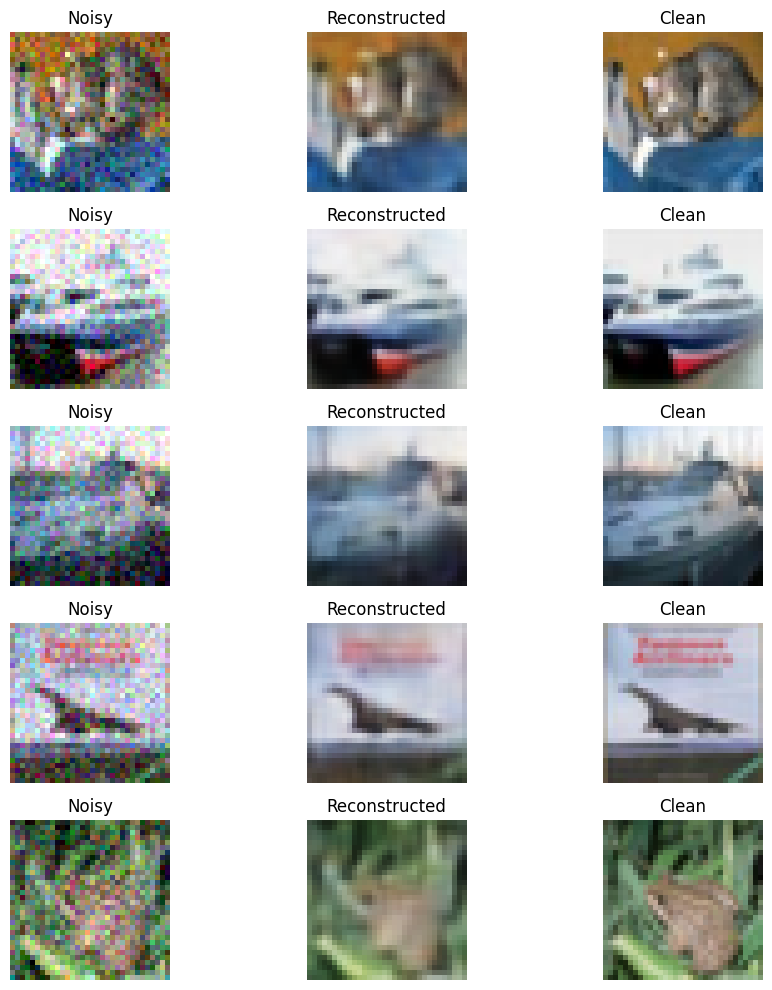

DDAE test PSNR: 22.15 dB, SSIM: 0.6668


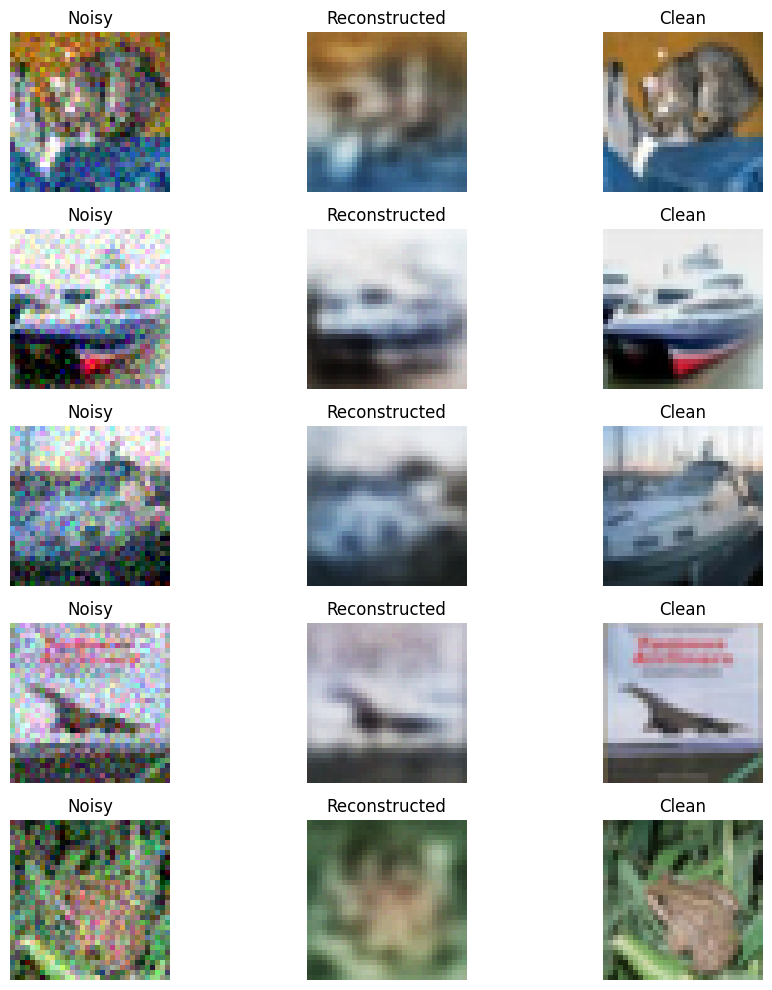

In [5]:
# Quantitative evaluation CDAE
psnr_score, ssim_score = cdae.evaluate(test_loader)
print(f"CDAE test PSNR: {psnr_score:.2f} dB, SSIM: {ssim_score:.4f}")
# Qualitative visualization CDAE
cdae.visualize_results(test_loader)

# Quantitative evaluation DDAE
psnr_score, ssim_score = ddae.evaluate(test_loader)
print(f"DDAE test PSNR: {psnr_score:.2f} dB, SSIM: {ssim_score:.4f}")
# Qualitative visualization DDAE
ddae.visualize_results(test_loader)

The experiments demonstrate that the convolutional DAE significantly outperforms its dense counterpart on CIFAR-10 image denoising. The architectural advantages of convolutional layers, preserving spatial relationships through local connectivity and weight sharing, led to a superior recosntruction quality (conv: 26.35 db vs dense: 22.15 db) and a better structural preservation (conv: 0.84 vs dense: 0.67), highlighting its inductive bias for image data.

These results align with theoretical expectations: convolutions exploit translation invariance and hierarchical feature learning, whereas dense layers struggle with the high dimensionality and spatial correlations in natural images.